# ECE 4194 Final Project. Spring 2019. The Ohio State University
## Authors: Michael Wharton.124, Alex Whitman.97, Benji Justice.251

This notebook is to train a resnet model to classify the actions specified in the dataset linked below.

Dataset: http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions



### Define packages to autoreload

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport models.resnet
%aimport utils.data_helpers

### Import necessary modules

In [3]:
# torch modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# import model
from models.resnet import resnet18

# data functions
from utils.data_helpers import load_data
from utils.data_helpers import har_dataset

# classics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

### Define model hyper parameters

In [4]:
# what percentage of data should be used for training 
split = 0.7

num_epoch = 500
lr = 0.5e-6
batch_size = 10
num_workers = 1

### Create Model

In [5]:
model = resnet18()

inplanes 36  planes 36
inplanes 36  planes 36
inplanes 36  planes 72
inplanes 72  planes 72
inplanes 72  planes 144
inplanes 144  planes 144
inplanes 144  planes 288
inplanes 288  planes 288
inplanes 288  planes 576
inplanes 576  planes 576


### Handle GPU

In [6]:
use_gpu=True
if torch.cuda.is_available() and use_gpu:
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor
    
    device = torch.device('cuda:3')
    model = model.to(device)
else:
    dtype = torch.FloatTensor
    ltype = torch.LongTensor
    device = torch.device('cpu')
    
print('device {} dtype {}'.format(device, dtype))

device cuda:3 dtype <class 'torch.cuda.FloatTensor'>


### Handle loss function and optimizer

In [7]:
crit = torch.nn.CrossEntropyLoss()
opt  = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

### Track stats

In [8]:
stats = np.zeros(shape=(num_epoch, 2, 2))

# indices
train = 0
test  = 1
acc   = 0
loss  = 1


### Load data

In [9]:
# ...
train_data, train_labels, test_data, test_labels = load_data()


In [10]:
# convert to torch Tensor objects
train_data = torch.Tensor(train_data)
train_labels = torch.Tensor(train_labels)

test_data = torch.Tensor(test_data)
test_labels = torch.Tensor(test_labels)

In [11]:
print(train_data.shape)
print(test_data.shape)

print(train_labels.shape)
print(test_labels.shape)

torch.Size([873, 2048, 6])
torch.Size([341, 2048, 6])
torch.Size([873])
torch.Size([341])


In [12]:
train_ds = har_dataset(train_data, train_labels)
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers)
train_batches = train_dl.__len__()

test_ds = har_dataset(test_data, test_labels)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)
test_batches = test_dl.__len__()

### Train !

In [13]:
tstart = time.time()
for epoch in range(num_epoch):
    
    # switch to train mode
    model.train()
    
    # track accuracy
    total = 0
    correct = 0
    
    # track loss
    tr_loss = []
    for batch, data in enumerate(train_dl):
        print('Training Iteration: {0:4d} of {1:4d}'.format(batch+1, train_batches), end='\r')
        
        # extract signal and labels
        signals, labels = data
        
        ## Normalize?
        
        # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
        signals = signals.transpose(1,2)
        
        # move data to device
        signals = signals.to(device)
        labels = labels.type(ltype).to(device)
        
        # process signals
        out = model(signals)
        
        # hard decision for classification
        _, pred = torch.max(out.data, 1)
        
#         print(pred)
#         print(labels)
#         print()
        
        # compute accuracy
        total   += labels.size(0)
        correct += (pred == labels).sum().item()
        
        # compute loss
        b_loss = crit(out, labels)
        opt.zero_grad()
        b_loss.backward()
        opt.step()
        
        tr_loss.append(b_loss.item())
    
    # epoch training stats
    tr_accuracy = 100. * correct / total
    tr_loss = np.mean(tr_loss)
    
    # evaluate model
    model.eval()
    
    ts_loss = []
    total   = 0
    correct = 0
    with torch.no_grad():
        for batch, data in enumerate(test_dl):
            print('Testing  Iteration:: {0:4d} or {1:4d}'.format(batch+1, test_batches), end='\r')
            
            # extract signals and labels
            signals, labels = data
            
            # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
            signals = signals.transpose(1,2)
            
            # move data to device
            signals = signals.to(device)
            labels = labels.type(ltype).to(device)
            
            # process signals
            out = model(signals)
            
            # hard decision for classification
            _, pred = torch.max(out.data, 1)
            
            # compute accuracy
            total   += labels.size(0)
            correct += (pred == labels).sum().item()
            
            # compute loss
            b_loss = crit(out, labels)
            
            ts_loss.append(b_loss.item())
            
    # epoch testing stats
    ts_accuracy = 100. * correct / total
    ts_loss = np.mean(ts_loss)
    
    # save stats to plot later
    stats[epoch, train, loss ] = tr_loss
    stats[epoch, train, acc  ] = tr_accuracy
    stats[epoch, test,  loss ] = ts_loss
    stats[epoch, test,  acc  ] = ts_accuracy
    
    t1 = time.time() - tstart
    print('Epoch: {0:4d} Tr loss: {1:.6f} Ts loss: {2:.3f} Tr Accuracy: {3:3.2f}% Ts Accuracy: {4:3.2f}% Time: {5:4.2f}s'.format(
            epoch+1,      tr_loss,         ts_loss,         tr_accuracy,           ts_accuracy, t1))

Epoch:    1 Tr loss: 2.680970 Ts loss: 2.488 Tr Accuracy: 9.28% Ts Accuracy: 11.14% Time: 8.77s
Epoch:    2 Tr loss: 2.303823 Ts loss: 2.255 Tr Accuracy: 16.61% Ts Accuracy: 18.48% Time: 11.78s
Epoch:    3 Tr loss: 2.072572 Ts loss: 2.104 Tr Accuracy: 24.74% Ts Accuracy: 21.99% Time: 15.01s
Epoch:    4 Tr loss: 1.905338 Ts loss: 1.989 Tr Accuracy: 31.16% Ts Accuracy: 24.93% Time: 18.06s
Epoch:    5 Tr loss: 1.765903 Ts loss: 1.892 Tr Accuracy: 39.86% Ts Accuracy: 31.38% Time: 21.33s
Epoch:    6 Tr loss: 1.643484 Ts loss: 1.807 Tr Accuracy: 47.65% Ts Accuracy: 36.36% Time: 24.65s
Epoch:    7 Tr loss: 1.534376 Ts loss: 1.730 Tr Accuracy: 54.64% Ts Accuracy: 39.30% Time: 27.66s
Epoch:    8 Tr loss: 1.436610 Ts loss: 1.662 Tr Accuracy: 60.48% Ts Accuracy: 43.40% Time: 31.08s
Epoch:    9 Tr loss: 1.348491 Ts loss: 1.600 Tr Accuracy: 67.24% Ts Accuracy: 46.63% Time: 34.03s
Epoch:   10 Tr loss: 1.268712 Ts loss: 1.543 Tr Accuracy: 72.28% Ts Accuracy: 49.56% Time: 36.91s
Epoch:   11 Tr loss: 1

Epoch:   84 Tr loss: 0.067937 Ts loss: 0.657 Tr Accuracy: 99.89% Ts Accuracy: 77.71% Time: 266.35s
Epoch:   85 Tr loss: 0.065463 Ts loss: 0.655 Tr Accuracy: 99.89% Ts Accuracy: 78.01% Time: 269.15s
Epoch:   86 Tr loss: 0.063080 Ts loss: 0.652 Tr Accuracy: 100.00% Ts Accuracy: 78.01% Time: 271.87s
Epoch:   87 Tr loss: 0.060778 Ts loss: 0.650 Tr Accuracy: 100.00% Ts Accuracy: 78.01% Time: 274.81s
Epoch:   88 Tr loss: 0.058559 Ts loss: 0.648 Tr Accuracy: 100.00% Ts Accuracy: 78.30% Time: 277.69s
Epoch:   89 Tr loss: 0.056420 Ts loss: 0.646 Tr Accuracy: 100.00% Ts Accuracy: 78.30% Time: 280.53s
Epoch:   90 Tr loss: 0.054354 Ts loss: 0.643 Tr Accuracy: 100.00% Ts Accuracy: 78.30% Time: 283.36s
Epoch:   91 Tr loss: 0.052363 Ts loss: 0.641 Tr Accuracy: 100.00% Ts Accuracy: 78.30% Time: 286.20s
Epoch:   92 Tr loss: 0.050443 Ts loss: 0.639 Tr Accuracy: 100.00% Ts Accuracy: 78.01% Time: 288.95s
Epoch:   93 Tr loss: 0.048591 Ts loss: 0.637 Tr Accuracy: 100.00% Ts Accuracy: 78.01% Time: 292.08s
Ep

Epoch:  166 Tr loss: 0.003041 Ts loss: 0.599 Tr Accuracy: 100.00% Ts Accuracy: 79.77% Time: 514.05s
Epoch:  167 Tr loss: 0.002926 Ts loss: 0.599 Tr Accuracy: 100.00% Ts Accuracy: 79.77% Time: 517.25s
Epoch:  168 Tr loss: 0.002816 Ts loss: 0.600 Tr Accuracy: 100.00% Ts Accuracy: 80.06% Time: 520.41s
Epoch:  169 Tr loss: 0.002710 Ts loss: 0.600 Tr Accuracy: 100.00% Ts Accuracy: 80.06% Time: 523.45s
Epoch:  170 Tr loss: 0.002607 Ts loss: 0.600 Tr Accuracy: 100.00% Ts Accuracy: 80.06% Time: 526.60s
Epoch:  171 Tr loss: 0.002509 Ts loss: 0.601 Tr Accuracy: 100.00% Ts Accuracy: 80.06% Time: 529.51s
Epoch:  172 Tr loss: 0.002414 Ts loss: 0.601 Tr Accuracy: 100.00% Ts Accuracy: 80.06% Time: 532.43s
Epoch:  173 Tr loss: 0.002323 Ts loss: 0.602 Tr Accuracy: 100.00% Ts Accuracy: 80.06% Time: 535.19s
Epoch:  174 Tr loss: 0.002234 Ts loss: 0.602 Tr Accuracy: 100.00% Ts Accuracy: 80.35% Time: 537.96s
Epoch:  175 Tr loss: 0.002150 Ts loss: 0.603 Tr Accuracy: 100.00% Ts Accuracy: 80.35% Time: 540.96s


Epoch:  248 Tr loss: 0.000122 Ts loss: 0.671 Tr Accuracy: 100.00% Ts Accuracy: 82.70% Time: 761.32s
Epoch:  249 Tr loss: 0.000118 Ts loss: 0.672 Tr Accuracy: 100.00% Ts Accuracy: 82.70% Time: 764.37s
Epoch:  250 Tr loss: 0.000113 Ts loss: 0.674 Tr Accuracy: 100.00% Ts Accuracy: 82.70% Time: 767.36s
Epoch:  251 Tr loss: 0.000108 Ts loss: 0.675 Tr Accuracy: 100.00% Ts Accuracy: 82.70% Time: 770.04s
Epoch:  252 Tr loss: 0.000104 Ts loss: 0.676 Tr Accuracy: 100.00% Ts Accuracy: 82.70% Time: 773.17s
Epoch:  253 Tr loss: 0.000100 Ts loss: 0.677 Tr Accuracy: 100.00% Ts Accuracy: 82.70% Time: 775.99s
Epoch:  254 Tr loss: 0.000096 Ts loss: 0.679 Tr Accuracy: 100.00% Ts Accuracy: 82.70% Time: 778.99s
Epoch:  255 Tr loss: 0.000092 Ts loss: 0.680 Tr Accuracy: 100.00% Ts Accuracy: 82.70% Time: 782.09s
Epoch:  256 Tr loss: 0.000089 Ts loss: 0.681 Tr Accuracy: 100.00% Ts Accuracy: 82.70% Time: 785.04s
Epoch:  257 Tr loss: 0.000085 Ts loss: 0.683 Tr Accuracy: 100.00% Ts Accuracy: 82.70% Time: 787.69s


Epoch:  330 Tr loss: 0.000004 Ts loss: 0.787 Tr Accuracy: 100.00% Ts Accuracy: 83.28% Time: 1005.51s
Epoch:  331 Tr loss: 0.000004 Ts loss: 0.788 Tr Accuracy: 100.00% Ts Accuracy: 83.28% Time: 1008.63s
Epoch:  332 Tr loss: 0.000004 Ts loss: 0.790 Tr Accuracy: 100.00% Ts Accuracy: 83.28% Time: 1011.49s
Epoch:  333 Tr loss: 0.000004 Ts loss: 0.791 Tr Accuracy: 100.00% Ts Accuracy: 83.28% Time: 1014.64s
Epoch:  334 Tr loss: 0.000004 Ts loss: 0.793 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1018.05s
Epoch:  335 Tr loss: 0.000004 Ts loss: 0.794 Tr Accuracy: 100.00% Ts Accuracy: 83.28% Time: 1021.24s
Epoch:  336 Tr loss: 0.000003 Ts loss: 0.796 Tr Accuracy: 100.00% Ts Accuracy: 83.28% Time: 1024.43s
Epoch:  337 Tr loss: 0.000003 Ts loss: 0.797 Tr Accuracy: 100.00% Ts Accuracy: 83.28% Time: 1027.96s
Epoch:  338 Tr loss: 0.000003 Ts loss: 0.799 Tr Accuracy: 100.00% Ts Accuracy: 83.28% Time: 1030.83s
Epoch:  339 Tr loss: 0.000003 Ts loss: 0.800 Tr Accuracy: 100.00% Ts Accuracy: 83.28% Time:

Epoch:  411 Tr loss: 0.000000 Ts loss: 0.885 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1249.22s
Epoch:  412 Tr loss: 0.000000 Ts loss: 0.886 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1251.92s
Epoch:  413 Tr loss: 0.000000 Ts loss: 0.887 Tr Accuracy: 100.00% Ts Accuracy: 83.28% Time: 1254.77s
Epoch:  414 Tr loss: 0.000000 Ts loss: 0.886 Tr Accuracy: 100.00% Ts Accuracy: 83.28% Time: 1257.87s
Epoch:  415 Tr loss: 0.000000 Ts loss: 0.888 Tr Accuracy: 100.00% Ts Accuracy: 83.28% Time: 1260.90s
Epoch:  416 Tr loss: 0.000000 Ts loss: 0.888 Tr Accuracy: 100.00% Ts Accuracy: 83.28% Time: 1264.02s
Epoch:  417 Tr loss: 0.000000 Ts loss: 0.889 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1266.88s
Epoch:  418 Tr loss: 0.000000 Ts loss: 0.888 Tr Accuracy: 100.00% Ts Accuracy: 83.28% Time: 1269.76s
Epoch:  419 Tr loss: 0.000000 Ts loss: 0.890 Tr Accuracy: 100.00% Ts Accuracy: 83.28% Time: 1272.71s
Epoch:  420 Tr loss: 0.000000 Ts loss: 0.892 Tr Accuracy: 100.00% Ts Accuracy: 83.28% Time:

Epoch:  492 Tr loss: 0.000000 Ts loss: 0.938 Tr Accuracy: 100.00% Ts Accuracy: 83.87% Time: 1492.69s
Epoch:  493 Tr loss: 0.000000 Ts loss: 0.938 Tr Accuracy: 100.00% Ts Accuracy: 83.87% Time: 1495.58s
Epoch:  494 Tr loss: 0.000000 Ts loss: 0.939 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1498.54s
Epoch:  495 Tr loss: 0.000000 Ts loss: 0.940 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1501.74s
Epoch:  496 Tr loss: 0.000000 Ts loss: 0.940 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1504.87s
Epoch:  497 Tr loss: 0.000000 Ts loss: 0.941 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1507.98s
Epoch:  498 Tr loss: 0.000000 Ts loss: 0.943 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1511.53s
Epoch:  499 Tr loss: 0.000000 Ts loss: 0.943 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1514.49s
Epoch:  500 Tr loss: 0.000000 Ts loss: 0.943 Tr Accuracy: 100.00% Ts Accuracy: 83.58% Time: 1517.63s


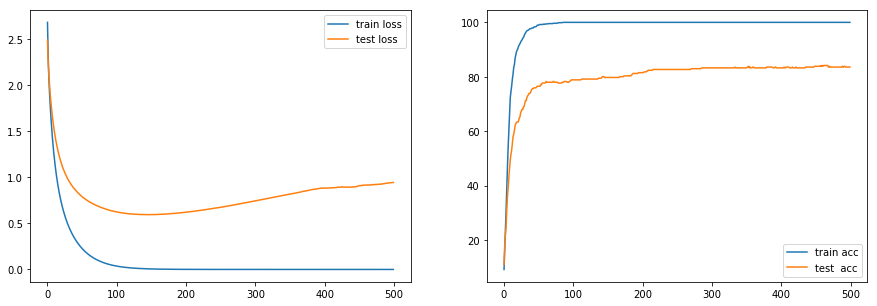

In [14]:
x = np.linspace(0,epoch,epoch+1)

tr_loss = stats[:,train,loss]
ts_loss = stats[:,test, loss]

tr_acc = stats[:, train, acc]
ts_acc = stats[:, test,  acc]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(x,tr_loss,label='train loss')
plt.plot(x,ts_loss,label='test loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,tr_acc,label='train acc')
plt.plot(x,ts_acc,label='test  acc')
plt.legend()

plt.show()